In [73]:
import scanpy as sc
from matplotlib import pyplot as plt
from pandas import get_dummies
import numpy as np
from contextlib import suppress
from sklearn.cluster import KMeans


In [76]:
def kmeans_inducing_pts(X,M):
  M = int(M)
  Z = np.unique(X, axis=0)
  unique_locs = Z.shape[0]
  if M<unique_locs:
    Z=KMeans(n_clusters=M).fit(X).cluster_centers_
  return Z

In [24]:
def scanpy_sizefactors(Y):
  sz = Y.sum(axis=1,keepdims=True)
  return sz/np.median(sz)

In [25]:
def rescale_spatial_coords(X,box_side=4):
  """
  X is an NxD matrix of spatial coordinates
  Returns a rescaled version of X such that aspect ratio is preserved
  But data are centered at zero and area of equivalent bounding box set to
  box_side^D
  Goal is to rescale X to be similar to a N(0,1) distribution in all axes
  box_side=4 makes the data fit in range (-2,2)
  """
  xmin = X.min(axis=0)
  X -= xmin
  x_gmean = np.exp(np.mean(np.log(X.max(axis=0))))
  X *= box_side/x_gmean
  return X - X.mean(axis=0)


In [30]:
def anndata_to_train_val(ad, layer=None, nfeat=None, train_frac=0.95,
                         sz="constant", dtp="float32", flip_yaxis=True):
  """
  Convert anndata object ad to a training data dictionary
  and a validation data dictionary
  Requirements:
  * rows of ad are pre-shuffled to ensure random split of train/test
  * spatial coordinates in ad.obsm['spatial']
  * features (cols) of ad sorted in decreasing importance (eg with deviance)
  """
  if nfeat is not None: ad = ad[:,:nfeat]
  N = ad.shape[0]
  Ntr = round(train_frac*N)
  X = ad.obsm["spatial"].copy().astype(dtp)
  if flip_yaxis: X[:,1] = -X[:,1]
  X = rescale_spatial_coords(X)
  if layer is None: Y = ad.X
  else: Y = ad.layers[layer]
  with suppress(AttributeError):
    Y = Y.toarray() #in case Y is a sparse matrix
  Y = Y.astype(dtp)
  Dtr = {"X":X[:Ntr,:], "Y":Y[:Ntr,:]}
  Dval = {"X":X[Ntr:,:], "Y":Y[Ntr:,:]}
  if sz=="constant":
    Dtr["sz"] = np.ones((Ntr,1),dtype=dtp)
    Dval["sz"] = np.ones((N-Ntr,1),dtype=dtp)
  elif sz=="mean":
    Dtr["sz"] = Dtr["Y"].mean(axis=1,keepdims=True)
    Dval["sz"] = Dval["Y"].mean(axis=1,keepdims=True)
  elif sz=="scanpy":
    Dtr["sz"] = scanpy_sizefactors(Dtr["Y"])
    Dval["sz"] = scanpy_sizefactors(Dval["Y"])
  else:
    raise ValueError("unrecognized size factors 'sz'")
  Dtr["idx"] = np.arange(Ntr)
  if Ntr>=N: Dval = None #avoid returning an empty array
  return Dtr, Dval

In [31]:
#%% Data loading
ad = sc.read_h5ad("../datasets/S1.h5ad")
ad = ad[:,:80]
X = ad.obsm["spatial"]
#raw count data for NSF
D, Dval = anndata_to_train_val(ad, layer="counts", train_frac=0.8, flip_yaxis=False)
Ntr,J = D["Y"].shape
Xtr = D["X"]
ad = ad[:Ntr,:]

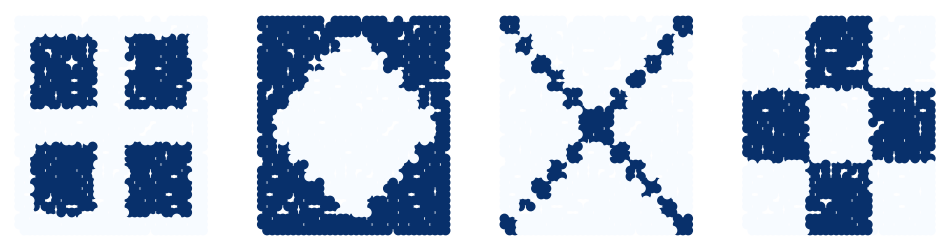

In [54]:
Ftrue = ad.obsm["spfac"]
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    ax[i].scatter(Xtr[:,0], Xtr[:, 1], c=Ftrue[:, i], cmap='Blues')
    ax[i].axis('off')

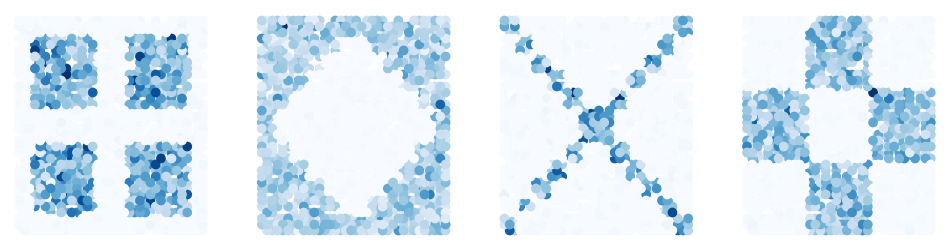

In [59]:
Yss = ad.layers["counts"][:,(4,0,1,2)]
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    ax[i].scatter(Xtr[:,0], Xtr[:, 1], c=Yss[:, i], cmap='Blues')
    ax[i].axis('off')

In [77]:
Z = kmeans_inducing_pts(Xtr, 500)

In [79]:
Z.shape

(500, 2)